In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [2]:
train      = pd.read_csv('data/train.csv', parse_dates=['date'])
test       = pd.read_csv('data/test.csv', parse_dates=['date']) # Reading test data
sample_sub = pd.read_csv('data/sample_submission.csv') # Reading the sample submission that is provided by Kaggle


In [3]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

RMSE 7.269014341615695


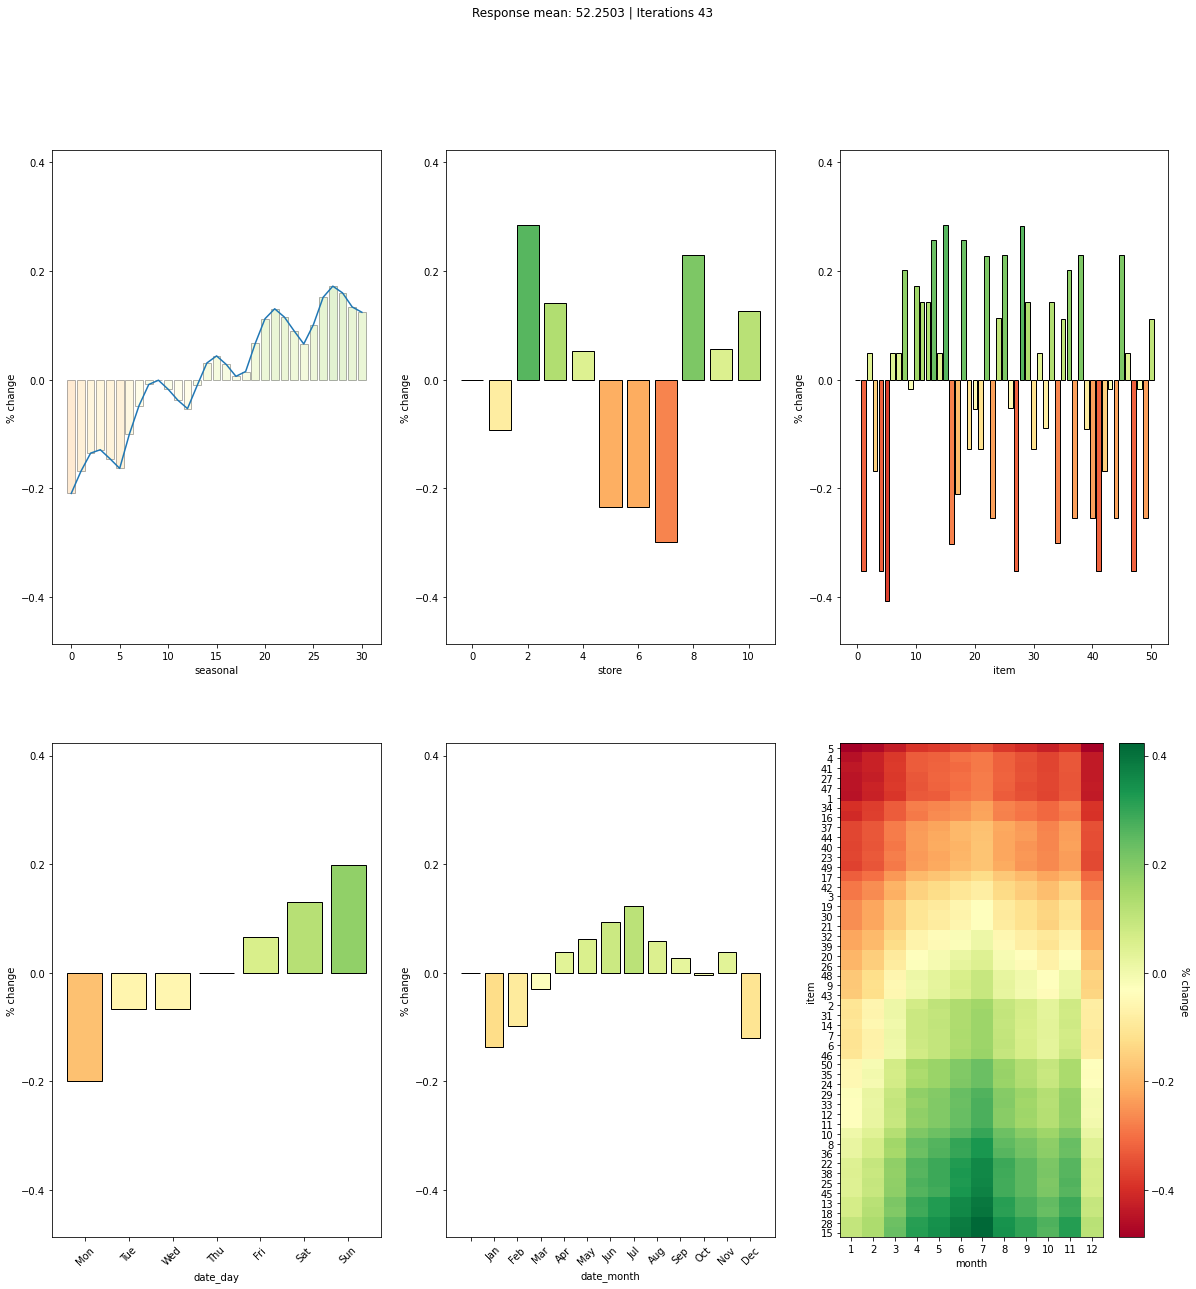

In [94]:
import cbm
from sklearn.metrics import mean_squared_error

# load data
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test  = pd.read_csv('data/test.csv',  parse_dates=['date']) 

# feature engineering
min_date = train['date'].min()

def featurize(df):
    out = pd.DataFrame({
        'seasonal' : (df['date'] - min_date).dt.days // 60, # TODO: for prediction such features need seperate modelling
        'store'    : df['store'], 
        'item'     : df['item'], 
        'date'     : df['date'],
        # <name-1> _X_ <name-2> to mark interaction features
        'item_X_month': df['item'].astype(str) + '_' + df['date'].dt.month.astype(str)
    })
    
    return out

x_train_df = featurize(train)
x_test_df  = featurize(test)
y_train = train['sales']

# model training
model = cbm.CBM()
model.fit(x_train_df, y_train)

# test on train error
y_pred_train = model.predict(x_train_df).flatten()
print('RMSE', mean_squared_error(y_pred_train, y_train, squared=False))

# plotting
model.plot_importance(figsize=(20, 20), continuous_features=['seasonal'])


In [ ]:
# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
# Validation set including first 3 months of 2017 (as we will forecast the first 3 months of 2018)
# val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [ ]:
train      = pd.read_csv('data/train.csv', parse_dates=['date'])

# train.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

# train = roll_mean_features(train, [365, 546])
# train = lag_features(train, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [ ]:
train

Test on train: 12.798603868130076 51.037721330095835
Test on test:  13.267740258991692 46.09033508231243


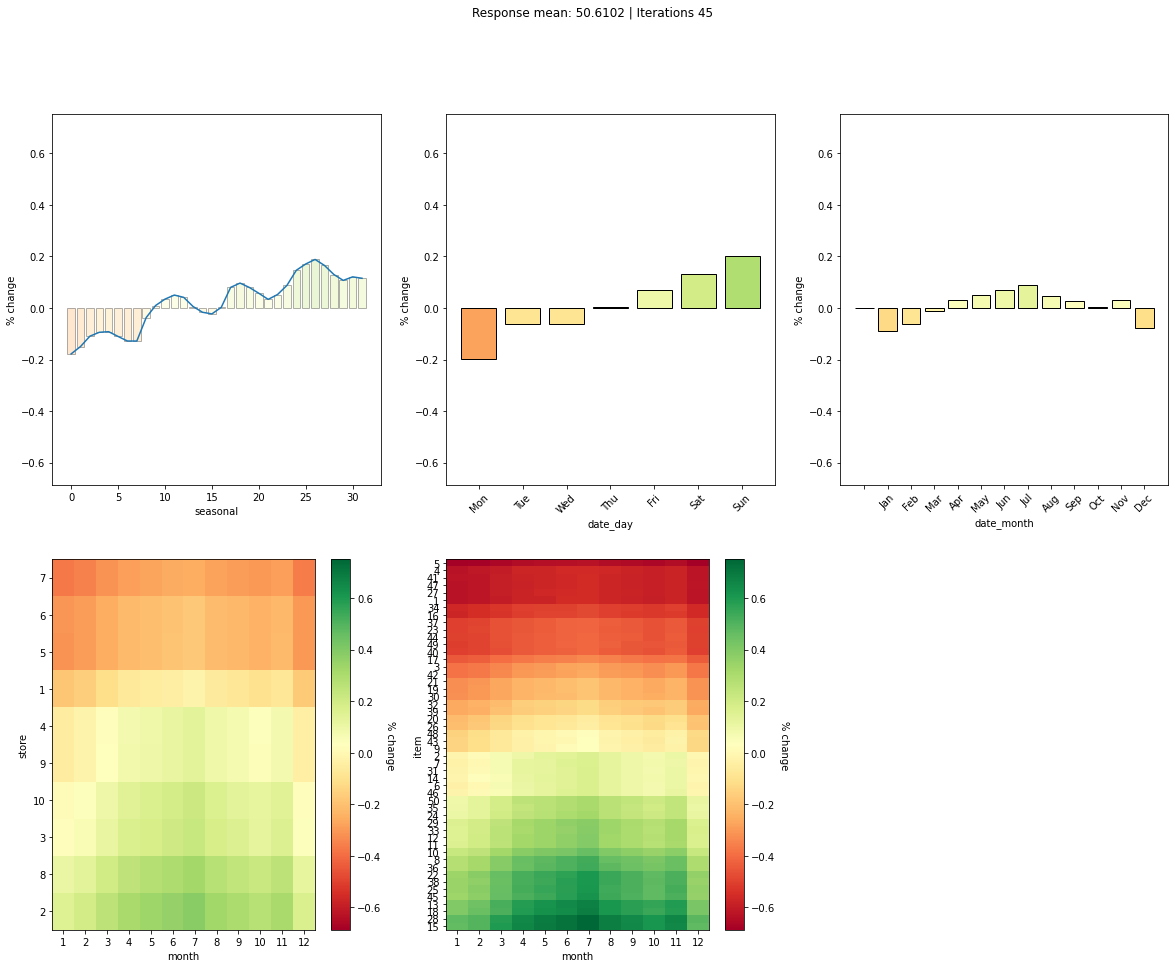

In [95]:
train_dt = train.pivot_table(index='date', columns=['store', 'item']).sort_index()

def featurize(df):
    out = pd.DataFrame({
        'seasonal' : (df['date'] - min_date).dt.days // 50,
        # 'store'    : df['store'], 
        # 'item'     : df['item'], 
        # 'month_begin': df['date'].dt.is_month_start,
        # build interaction feature
        # 'store_item' : df['item'].astype(str) + '_' + df['store'].astype(str),
        'date'        : df['date'],
        # 'sales_lag_364': df['sales_lag_364'],
        # 'sales_roll_mean_365': df['sales_roll_mean_365'],
        # 'sales_roll_mean_546': df['sales_roll_mean_546'],
        # 'dayofyear'   : df['date'].dt.dayofyear,
        'store_X_month'     : df['store'].astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'store_dayofweek' : df['store'].astype(str) + '_' + df['date'].dt.dayofweek.astype(str),
        'item_X_month'      : df['item'].astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'item_dayofweek'    : df['item'].astype(str) + '_' + df['date'].dt.dayofweek.astype(str),
        # 'weekofmonth_month' : df['date'].dt.weekofmonth.astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'weekofmonth_month' : df['date'].dt.weekofmonth.astype(str) + '_' + df['store'].astype(str),
    })
    
    return out

train_Xy = train.loc[(train["date"] < "2017-01-01"), :].dropna()

# Validation set including first 3 months of 2017 (as we will forecast the first 3 months of 2018)
test_Xy = train.loc[(train["date"] >= "2017-01-01") & (train["date"] < "2017-04-01"), :]
if True:    
    
# tscv = TimeSeriesSplit(n_splits=5, test_size=90)
# for train_idx, test_idx in tscv.split(train_dt):
#     train_Xy = train_dt.iloc[train_idx,].unstack().reset_index().rename({0: 'sales'}, axis=1)
#     test_Xy =  train_dt.iloc[test_idx, ].unstack().reset_index().rename({0: 'sales'}, axis=1)

    # print(f'Setup {len(train_idx)}: {min(test_idx)} to {max(test_idx)}')
    # print(sum(train_idx))
    
    train_df = featurize(train_Xy)
    test_df  = featurize(test_Xy)
    
    model = cbm.CBM() # binning=40) # learning_rate_step_size=1/400) #epsilon_early_stopping=1e-7) # metric='smape') # learning_rate_step_size=1/400)
    model.fit(train_df, train_Xy['sales'])

    y_pred = model.predict(train_df).flatten()
    print('Test on train:', smape(y_pred, train_Xy['sales']), mean_squared_error(y_pred, train_Xy['sales']))
    
    # forward
    from sktime.forecasting.exp_smoothing import ExponentialSmoothing
    from sktime.utils.plotting import plot_series

    y_dummy = np.array(model.weights[0])
    y_dummy_ts = pd.Series(y_dummy)

    fh = np.arange(-len(y_dummy_ts)+1, # cover the training period
                   test_df['seasonal'].max() + 2 - len(y_dummy_ts) # cover the test period
                  )

    forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=5)
    forecaster.fit(y_dummy_ts)
    y_pred = forecaster.predict(fh=fh)    
    
    w = model.weights
    w[0] = y_pred
    model.update(w, model.y_mean)
    
    # test n
    y_pred = model.predict(test_df).flatten()
    
    print('Test on test: ', smape(y_pred, test_Xy['sales']), mean_squared_error(y_pred, test_Xy['sales']))
    
model.plot_importance(figsize=(20, 15), continuous_features=['seasonal'])
# 13.589953604669455
# 13.449736631731762
# 13.267740258991692

In [37]:
plt.get_cmap("RdYlGn")(1)

(0.6547481737793157, 0.007381776239907728, 0.14917339484813533, 1.0)

In [175]:
test['date'].nunique()

90

0.6519865732958832

In [67]:
def plot_heatmap(data_series, weights, ax=None, vmin=None, vmax=None):
    story_month_cat = data_series.astype('category')
    # # train_df['store_month'].astype('category')

    cat_df = pd.DataFrame(
        [(int(c.split('_')[0]), int(c.split('_')[1]), i) for i, c in enumerate(story_month_cat.cat.categories)],
        columns=['f0', 'f1', 'idx'])

    cat_df.sort_values(['f0', 'f1'], inplace=True)

    cat_df_2d = cat_df.pivot(index='f0', columns='f1', values='idx')
    
    # resort index by mean weight value
    zi = np.array(weights)[cat_df_2d.to_numpy()]
    
    sort_order = np.argsort(np.max(zi, axis=1))
    cat_df_2d = cat_df_2d.reindex(cat_df_2d.index[sort_order])
    
    xi = cat_df_2d.columns
    yi = cat_df_2d.index
    zi =  np.array(weights)[cat_df_2d.to_numpy()]

    # CS = plt.contourf(xi, yi, zi, 15, cmap=plt.get_cmap("RdYlGn"))

    if ax is None:
        fig, ax = plt.subplots()
        
    im = ax.imshow(zi, cmap=plt.get_cmap("RdYlGn"), aspect='auto', vmin=vmin, vmax=vmax)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(data_series.name, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(xi)), labels=xi)
    ax.set_yticks(np.arange(len(yi)), labels=yi)
    
# plt.colorbar()  
# plt.show()
crossing = ['store_month', 'store_dayofweek', 'item_month', 'item_dayofweek']

vmin = np.min([np.min(model.weights[i]) for i in range(6, 10)])
vmax = np.max([np.max(model.weights[i]) for i in range(6, 10)])

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for i, f in enumerate(crossing):
    plot_heatmap(train_df[f], model.weights[6+i], ax = ax[i//2, i%2], vmin=vmin, vmax=vmax)

IndexError: list index out of range

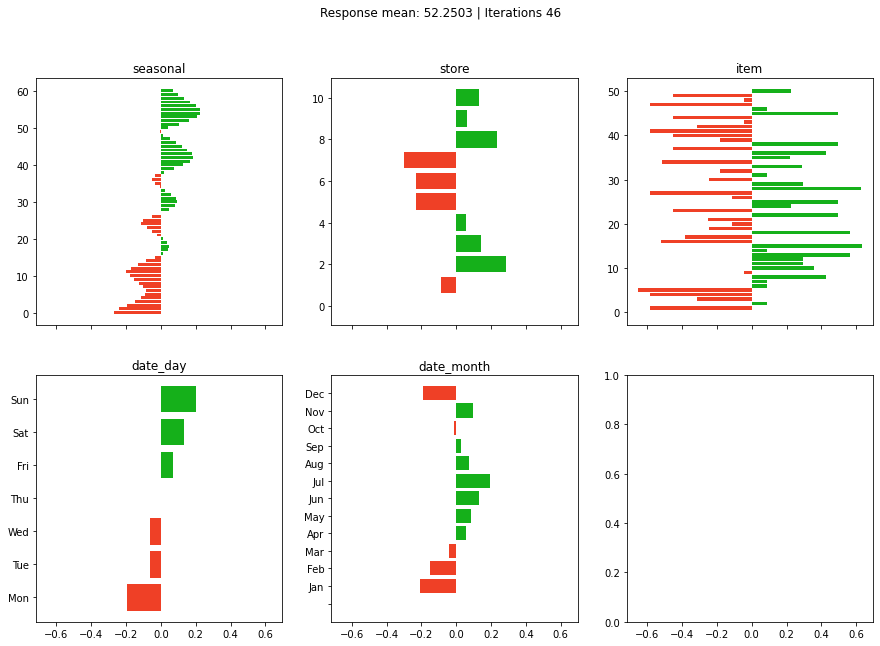

In [9]:
model.plot_importance(figsize=(15, 10))    

<AxesSubplot:xlabel='item'>

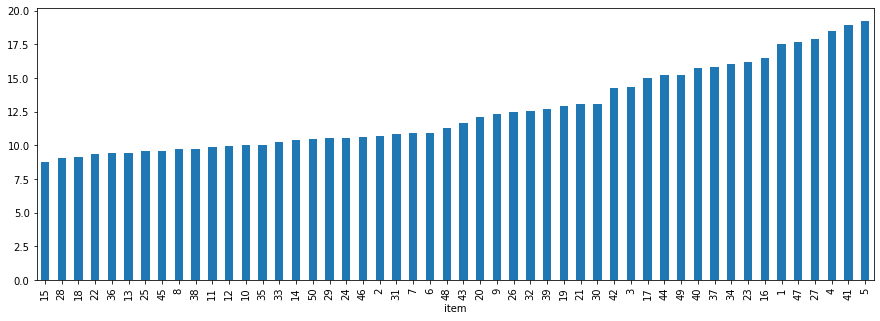

In [28]:
eval_df = pd.concat([test_Xy, pd.Series(y_pred, name='pred')], axis=1)

(eval_df.groupby('item')
     .apply(lambda g: smape(g['pred'], g['sales']))
     .sort_values()
     .plot.bar(figsize=(15, 5)))

<AxesSubplot:xlabel='store'>

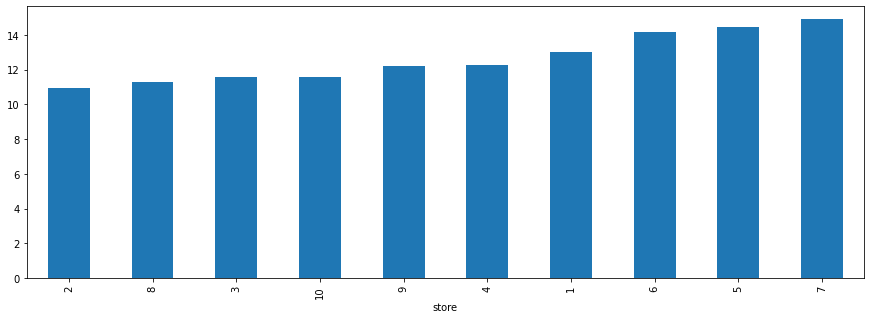

In [10]:
(eval_df.groupby('store')
     .apply(lambda g: smape(g['pred'], g['sales']))
     .sort_values()
     .plot.bar(figsize=(15, 5)))